Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops import array_ops

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name))
  f.close()
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [5]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

In [6]:
def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

In [7]:
print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [7]:
batch_size=256
num_unrollings=10

In [8]:
class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'bout it in ', 'nomination ', 'lower here ', 'when milita', 'ogenetic ap', ' three nine', 'unced that ', 'lleria arch', 'any he did ', 'reviated as', 'unce the wo', ' abbeys and', 'one a a gen', 'shing the r', 's of it to ', 'married urr', 'ouncil twic', 'sity upset ', 'toon advent', 'hel and ric', 't used the ', 'ased in the', 'settled the', 'y and litur', 'nes flight ', ' disgust be', 'tury the wa', 'ay opened f', ' were a tri', 'society and', 'hree mm zer', 'tion from t', 'y the human', 'ago based c', 'each the dh', 'migration t', 's one zero ', ' zero zero ', 'rick and al', 'new york ot', 'ycles have ', 'short subje', 'sample code', 'he boeing s', 'em a year l', 'sgow two yo', 'ne nine eig', 'e listed wi', 'ill even mo', 'lt during t', 'ine one it ', 'eber has pr', ' x three an', ' not dead n', 'f the team ', 'o be made t', 'hy essentia', 'll s enthus', 'unds the mo', 'yer who rec', ' a step or ', 'operates th', 's has been ', 'ore signifi', ' community ', 'rmines s

In [9]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

In [10]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):

    ic = tf.matmul(i, array_ops.concat(concat_dim=1, values=[ix,fx,cx,ox]))
    oc = tf.matmul(o, array_ops.concat(concat_dim=1, values=[im,fm,cm,om]))
    
    iix, ifx, icx, iox = array_ops.split(1, 4, ic)
    oim, ofm, ocm, oom = array_ops.split(1, 4, oc)
    
    input_gate = tf.sigmoid(iix + oim + ib)
    forget_gate = tf.sigmoid(ifx + ofm + fb)
    output_gate = tf.sigmoid(iox + oom + ob)
    
    update = icx + ocm + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        logits, tf.concat(0, train_labels)))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [11]:
num_steps = 9001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(np.exp(logprob(predictions, labels))))
    
      #print (predictions.shape, predictions)
      #print (labels.shape, labels)
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.296965 learning rate: 10.000000
Minibatch perplexity: 27.03
r e noovaw  npbnacesomrtyrduot tliefxdsn k ksowinoepvvuzr  nshbyynzeo htoenimx h
hmzgqoecpmta nirkeiod ogzv tir lycpd wbceh vm d s e qeejt vypodueeapatbvt ouvbzo
nd nvts omynenissflv gnolbn ogoid abf eelpcy pc tibx  e leelu xbxwazp xmhdor tkn
uiecbyqsdt  pz eecqgeewbeq aphfntaitsaue nrvemedagrxoknozeqaj zwspyldzstoei ngpa
k rrn  rygcjjxjsi ceogo df htcpows z nafntlmbdxobqgb xorr e   qavfe xtocbloc jir
Validation set perplexity: 20.21
Average loss at step 100: 2.580279 learning rate: 10.000000
Minibatch perplexity: 10.97
Validation set perplexity: 10.29
Average loss at step 200: 2.223583 learning rate: 10.000000
Minibatch perplexity: 8.40
Validation set perplexity: 8.67
Average loss at step 300: 2.068864 learning rate: 10.000000
Minibatch perplexity: 7.09
Validation set perplexity: 7.68
Average loss at step 400: 1.965543 learning rate: 10.000000
Minibatch perplexity: 6.99
Validation set per

In [12]:
import cPickle
import sys

def dump_obj(obj, fname):
    try:
        f = file(fname, 'wb')
        cPickle.dump(obj, f, protocol=cPickle.HIGHEST_PROTOCOL)
        f.close()
        return 1
    except Exception as e:
        print(e)
        return 0

def load_obj(fname):
    try:
        f = file(fname, 'rb')
        loaded_obj = cPickle.load(f)
        f.close()
        return loaded_obj
    except Exception as e:
        print(e)
        return 0

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [13]:
def my_lstm_cell(i, o, state):

    ic = tf.matmul(i, array_ops.concat(concat_dim=1, values=[ix,fx,cx,ox]))
    oc = tf.matmul(o, array_ops.concat(concat_dim=1, values=[im,fm,cm,om]))
    
    iix, ifx, icx, iox = array_ops.split(1, 4, ic)
    oim, ofm, ocm, oom = array_ops.split(1, 4, oc)
    
    input_gate = tf.sigmoid(iix + oim + ib)
    forget_gate = tf.sigmoid(ifx + ofm + fb)
    output_gate = tf.sigmoid(iox + oom + ob)
    
    update = icx + ocm + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    
    return output_gate * tf.tanh(state), state

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [13]:
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from itertools import compress
from IPython import display
from nltk import bigrams as tobigrams

import matplotlib.pyplot as plt
import collections
import math

def to_bigrams(text, overlap=False):
    """Convert a string of text to a list of bigrams"""
    bg = tobigrams(text)
    if overlap: return [''.join(t) for t in bg]
    else: return [''.join(t) for i, t in enumerate(bg) if i%2==0]

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [14]:
bg = to_bigrams(text, overlap=True)
print(len(bg))

99999999


In [16]:
bg[:13]

[' a', 'an', 'na', 'ar', 'rc', 'ch', 'hi', 'is', 'sm', 'm ', ' o', 'or', 'ri']

In [17]:
voc_size = 9001

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(voc_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

datum, count, dictionary, reverse_dictionary = build_dataset(bg)
voc_size = len(dictionary)

vocabulary_size = voc_size

print('Dictionary size:', voc_size)
print('Most common words (+UNK)', count[:5])
print('Sample data', datum[:10], '===', ''.join([reverse_dictionary[t] for t in datum[:10]]))

data_index = 0

Dictionary size: 729
Most common words (+UNK) [['UNK', 0], ('e ', 3686256), (' t', 2449254), ('s ', 2222333), ('th', 1980538)]
Sample data [5, 14, 97, 31, 218, 79, 75, 33, 267, 92] ===  aannaarrcchhiissmm 


In [18]:
def generate_batch_skipgram(dat, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) # used for collecting data[data_index] in the sliding window
    for _ in range(span):
            buffer.append(dat[data_index])
            data_index = (data_index + 1) % len(dat)
    for i in range(batch_size // num_skips):
            target = skip_window  # target label at the center of the buffer
            targets_to_avoid = [ skip_window ]
            for j in range(num_skips):
                while target in targets_to_avoid:
                    target = random.randint(0, span - 1)
                targets_to_avoid.append(target)
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[target]
            buffer.append(dat[data_index])
            data_index = (data_index + 1) % len(dat)
    return batch, labels

In [19]:
architecture = 'SKIP'

batch_size = 512
embedding_size = 64 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

if architecture == 'CBOW':
    input_shape = [batch_size, num_skips]
    generate_batch = generate_batch_cbow
elif architecture == 'SKIP':
    input_shape = [batch_size]
    generate_batch = generate_batch_skipgram


graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=input_shape)
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([voc_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([voc_size]))
  
  if architecture == 'SKIP':
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
  elif architecture == 'CBOW':
    emb = tf.zeros([batch_size, embedding_size])
    for j in range(num_skips):
        emb += tf.nn.embedding_lookup(embeddings, train_dataset[:, j])
    embed = emb

  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                   train_labels, num_sampled, voc_size))  

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Average loss at step 50000: 1.527570


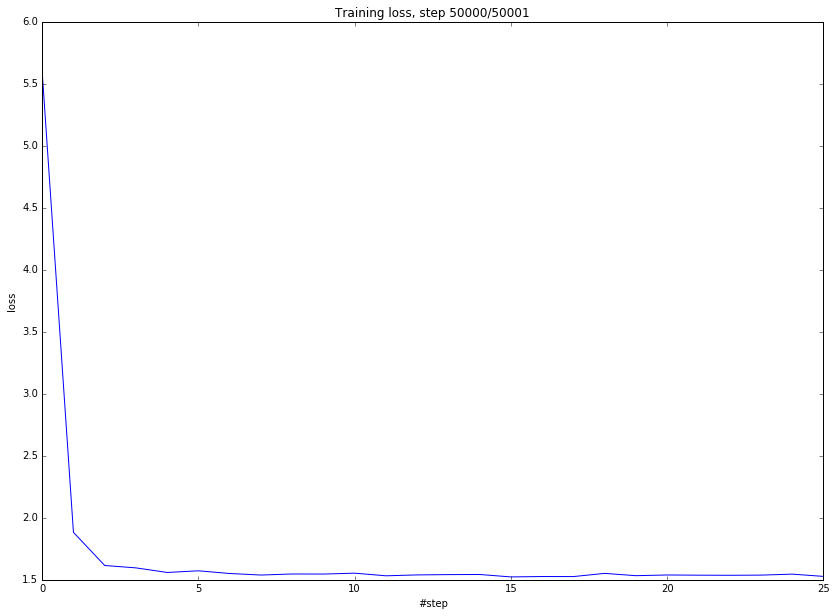

Nearest to  a:  t, ea,  i,  b,  o, fa,  w,  u,
Nearest to fo: fa, fu, fi, fr, bo, ho, xg, fs,
Nearest to  t:  a,  i, gk,  c,  b,  w,  q, dt,
Nearest to at: dt, ht, rt, ct, xt, nt, pt, xd,
Nearest to  e: gj, xe, ye, oe,  p, kw,  b, we,
Nearest to na: nm, ne, nw, ni, nk, qv, sa, oa,
Nearest to in: on, yn, wn, ii, id, un, ic, it,
Nearest to to: io, wo, tr, ho, th, ti, tu, lo,
Nearest to or: ur, ar, oc, ou, oi, ir, on, tq,
Nearest to as: ns, es, rs, ys, ad, is, gs, av,
Nearest to ha: hi, ho, hu, ja, hy, ka, he, fa,
Nearest to m : kq, ms, h , mp, md, fd, g , z ,
Nearest to  d:  q, bq, dd, cd,  z, nd,  j,  c,
Nearest to ea: oa, eg, ei, ev, la,  a, ec, ej,
Nearest to  o:  h, zf,  c,  i,  m,  a, mo,  w,
Nearest to ed: sd, md, nd, e , ew, kc, ex, em,


In [20]:
num_steps = 50001
lh = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
        
    batch_data, batch_labels = generate_batch(datum, batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += l
    
    if step % 2000 == 0:
      display.clear_output(wait=True)
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      lh.append(average_loss)
      average_loss = 0
            
      plt.figure(figsize=(14, 10))

      plt.title("Training loss, step {}/{}".format(step, num_steps))
      plt.xlabel("#step")
      plt.ylabel("loss")
      plt.plot(lh, 'b')
      plt.show()
      

    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
        
  final_embeddings = normalized_embeddings.eval()

In [22]:
dump_obj(final_embeddings, 'embeddings.pkl')

1

In [23]:
BI_EMB = load_obj('embeddings.pkl')

In [24]:
VALID_SIZE = 1000

# model parameters
BATCH_SIZE = 256
NUM_UNROLLINGS = 10
NUM_NODES = 256
SUMMARY_FREQUENCY = 100
EMBEDDING_DIMENSION = 64
DROPOUT_PROBABILITY = 0.34

CHARACTER_SIZE = (len(string.ascii_lowercase) + 1)  # [a-z] + ' '
VOCABULARY_SIZE = CHARACTER_SIZE ** 2  # [a-z] + ' ' (bigram)

FIRST_LETTER = ord(string.ascii_lowercase[0])

In [25]:
def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - FIRST_LETTER + 1
    elif char == ' ':
        return 0
    else:
        print('Unexpected character: %s' % char)
        return 0


def bigram2id(bigram):
    """easily extensible to ngram2id actually"""
    assert len(bigram) == 2, 'Input needs to be 2 characters.'
    char_id = 0

    for digit, char in enumerate(bigram):
        char_id += char2id(char) * (CHARACTER_SIZE ** digit)

    return char_id


def id2char(char_id):
    if char_id > 0:
        return chr(char_id + FIRST_LETTER - 1)
    else:
        return ' '

def id2bigram(char_id):
    first_digit_id = char_id % CHARACTER_SIZE
    second_digit_id = char_id // CHARACTER_SIZE

    return id2char(first_digit_id) + id2char(second_digit_id)


class BatchGenerator(object):
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [offset * segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, VOCABULARY_SIZE), dtype=np.float)

        for batch_id in range(self._batch_size):
            batch[batch_id, bigram2id(self._text[self._cursor[batch_id]: self._cursor[batch_id] + 2])] = 1.0
            self._cursor[batch_id] = (self._cursor[batch_id] + 2) % (self._text_size - 1)

        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]

        for step in range(self._num_unrollings):
            batches.append(self._next_batch())

        self._last_batch = batches[-1]

        return batches


def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(char_id) for char_id in np.argmax(probabilities, 1)]


def bigrams(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    bigrams back into its (most likely) bigram representation."""
    return [id2bigram(bigram_id) for bigram_id in np.argmax(probabilities, 1)]


def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    string = [''] * batches[0].shape[0]

    for batch in batches:
        string = [''.join(string_tuple) for string_tuple in zip(string, characters(batch))]

    return string


def log_prob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]


def sample_distribution(distribution):
    """Sample one element from a distribution assumed to be an array of normalized probabilities."""
    r = random.uniform(0, 1)
    s = 0

    for i in range(len(distribution)):
        s += distribution[i]

        if s >= r:
            return i

    return len(distribution) - 1

def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, VOCABULARY_SIZE], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p


def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, VOCABULARY_SIZE])
    return b / np.sum(b, 1)[:, None]


def bigram_label2unigram_label(bigram_one_hot_encodings, batch_size=BATCH_SIZE):
    unigram_id_labels = np.where(bigram_one_hot_encodings == 1)[1] // CHARACTER_SIZE
    return np.array([[float(char_id == unigram_id_labels[batch_id]) for char_id in range(CHARACTER_SIZE)] for batch_id in range(batch_size)])

In [31]:
def TrainBigramLSTM(text, nsteps, embeddings=None):
    
    valid_text = text[:VALID_SIZE]
    train_text = text[VALID_SIZE:]
    train_size = len(train_text)

    train_batches = BatchGenerator(train_text, BATCH_SIZE, NUM_UNROLLINGS)
    valid_batches = BatchGenerator(valid_text, 1, 1)

    # simple LSTM Model
    graph = tf.Graph()
    with graph.as_default():
        # Parameters for input, forget, cell state, and output gates
        W_lstm = tf.Variable(tf.truncated_normal([EMBEDDING_DIMENSION + NUM_NODES, NUM_NODES * 4]))
        b_lstm = tf.Variable(tf.zeros([1, NUM_NODES * 4]))

        # Variables saving state across unrollings.
        previous_output = tf.Variable(tf.zeros([BATCH_SIZE, NUM_NODES]), trainable=False)
        previous_state = tf.Variable(tf.zeros([BATCH_SIZE, NUM_NODES]), trainable=False)

        # Classifier weights and biases.
        W = tf.Variable(tf.truncated_normal([NUM_NODES, VOCABULARY_SIZE], -0.1, 0.1))
        b = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

        # embedding
        if embeddings is not None:
            print('Loading embeddings with shape {} ...'.format(embeddings.shape))
            embeddings = tf.Variable(embeddings)
        else:
            embeddings = tf.Variable(tf.random_uniform([VOCABULARY_SIZE, EMBEDDING_DIMENSION], minval=-1.0, maxval=1.0))

        # Definition of the cell computation.
        def lstm_cell(X, output, state):

            X_output = tf.concat(1, [X, output])
            all_logits = tf.matmul(X_output, W_lstm) + b_lstm

            input_gate = tf.sigmoid(all_logits[:, :NUM_NODES])
            forget_gate = tf.sigmoid(all_logits[:, NUM_NODES: NUM_NODES * 2])
            output_gate = tf.sigmoid(all_logits[:, NUM_NODES * 2: NUM_NODES * 3])
            temp_state = all_logits[:, NUM_NODES * 3:]
            state = forget_gate * state + input_gate * tf.tanh(temp_state)

            return output_gate * tf.tanh(state), state


        # Input data.
        train_X = list()
        train_labels = list()
        for _ in range(NUM_UNROLLINGS):
            train_X.append(tf.placeholder(tf.int32, shape=[BATCH_SIZE, 1]))
            train_labels.append(tf.placeholder(tf.float32, shape=[BATCH_SIZE, VOCABULARY_SIZE]))

        # Unrolled LSTM loop.
        outputs = list()
        output = previous_output
        state = previous_state

        for X in train_X:
            embed = tf.reshape(tf.nn.embedding_lookup(embeddings, X), shape=[BATCH_SIZE, -1])
            output, state = lstm_cell(embed, output, state)
            outputs.append(output)

        # State saving across unrollings.
        with tf.control_dependencies([previous_output.assign(output), previous_state.assign(state)]):
            # Classifier.
            logits = tf.nn.xw_plus_b(tf.nn.dropout(tf.concat(0, outputs), DROPOUT_PROBABILITY), W, b)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf.concat(0, train_labels)))

        # Optimizer.
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(10.0, global_step, 5000, 0.1, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        gradients, v = zip(*optimizer.compute_gradients(loss))
        gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
        optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)

        # Predictions.
        train_prediction = tf.nn.softmax(logits)

        # Sampling and validation eval: batch 1, no unrolling.
        sample_input = tf.placeholder(tf.int32, shape=[1, 1])
        sample_embed = tf.reshape(tf.nn.embedding_lookup(embeddings, sample_input), shape=[1, -1])
        previous_sample_output = tf.Variable(tf.zeros([1, NUM_NODES]))
        previous_sample_state = tf.Variable(tf.zeros([1, NUM_NODES]))
        reset_sample_state = tf.group(previous_sample_output.assign(tf.zeros([1, NUM_NODES])), previous_sample_state.assign(tf.zeros([1, NUM_NODES])))
        sample_output, sample_state = lstm_cell(sample_embed, previous_sample_output, previous_sample_state)

        with tf.control_dependencies([previous_sample_output.assign(sample_output), previous_sample_state.assign(sample_state)]):
            sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, W, b))


    # Run the model
    with tf.Session(graph=graph) as session:
        lh = []
        tf.initialize_all_variables().run()
        print('Initialized')
        mean_loss = 0

        for step in range(nsteps):
            batches = train_batches.next()
            feed_dict = dict()

            for batch_id in range(NUM_UNROLLINGS):
                feed_dict[train_X[batch_id]] = np.where(batches[batch_id] == 1)[1].reshape((-1, 1))
                feed_dict[train_labels[batch_id]] = batches[batch_id + 1]

            _, l, predictions, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)

            mean_loss += l

            if step % SUMMARY_FREQUENCY == 0:
                if step > 0:
                    mean_loss = mean_loss / SUMMARY_FREQUENCY
                display.clear_output(wait=True)
                lh.append(mean_loss)
                # The mean loss is an estimate of the loss over the last few batches.
                print('Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
                
                plt.figure(figsize=(14, 10))
                plt.title("Training loss, step {}/{}".format(step, nsteps))
                plt.xlabel("step")
                plt.ylabel("loss")
                plt.plot(lh, 'b')
                plt.show()

                mean_loss = 0
                labels = np.concatenate([batch for batch in batches[1:]])
                #print('Minibatch perplexity: %.2f' % float(np.exp(log_prob(predictions, labels))))

                
                if step % (SUMMARY_FREQUENCY * 10) == 0:
                    # Generate some samples.
                    thoughts = []

                    for _ in range(3):
                        feed = sample(random_distribution())
                        sentence = bigrams(feed)[0]
                        reset_sample_state.run()

                        for _ in range(140):
                            feed = np.where(feed == 1)[1].reshape((-1, 1))
                            prediction = sample_prediction.eval({sample_input: feed})
                            feed = sample(prediction)
                            sentence += ''.join(bigrams(feed))
                            last_bigram_id = bigram2id(sentence[-2:])
                            feed = np.array([[float(last_bigram_id == bigram_id) for bigram_id in range(VOCABULARY_SIZE)]])                    
                        thoughts.append(sentence)
                    
                print('=' * 80)
                print('Networks says:', '\n'.join(thoughts))
                print('=' * 80)

                # Measure validation set perplexity.
                reset_sample_state.run()
                valid_log_prob = 0

                for _ in range(VALID_SIZE):
                    valid_batch = valid_batches.next()
                    predictions = sample_prediction.eval({sample_input: np.where(valid_batch[0] == 1)[1].reshape((-1, 1))})
                    valid_log_prob = valid_log_prob + log_prob(predictions, valid_batch[1])

                print('Validation set perplexity: %.2f' % float(np.exp(valid_log_prob / VALID_SIZE)))
                
    return session

Average loss at step 50000: 3.540694 learning rate: 0.000000


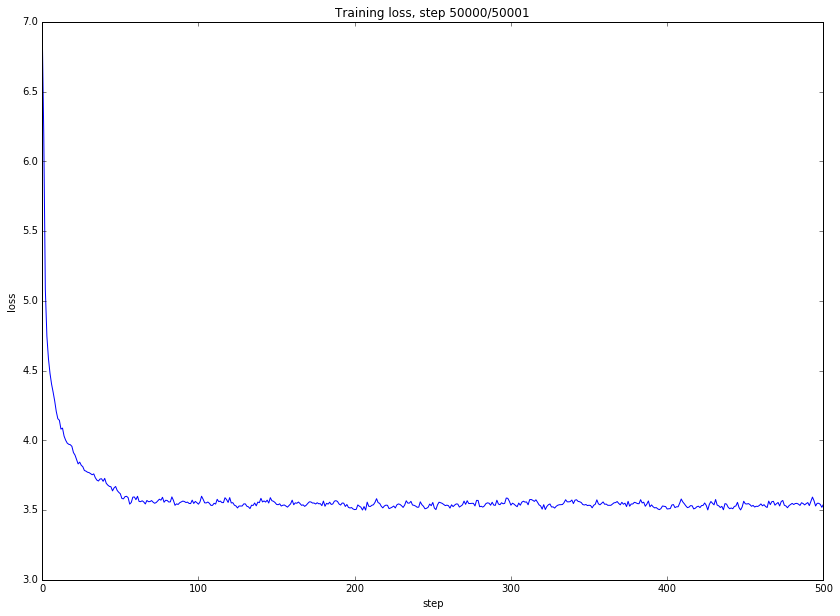

Networks says: wer legeut of for senia crisbanecal courival compeecaustion the persred for an later it had anke ud daeu the osh prole chop rive bjofence veaiyt prefeelliome inriances nal thnist to dito when bodyoril eous an and of majos noth injindime moderabarnne exus huma and wa super genhal in
ge from with the populion with writters into and like withirted ton links five ever for more at chroot epitaded the oepend somating to loanichage producst iq le seapsed based by the hat red the skun production his work used thed progratuswotion reprita were in the matures addariall
gkiricer of the plosottals hea of only jrations to the rightent feate ar from one km that agued inditudarligs ast of all five don to the whots hom linal fores the oras hymechurned from the st ndy but is one of the manded by up being vif per the valycwer attionato af wife north and 
Validation set perplexity: 22.10


In [32]:
sesh = TrainBigramLSTM(text, 50001, BI_EMB)


Networks says: xs loss of the movain theory gain the termle lessed to purow a pularle spuy not year as yeard dot wrarget zero rearts other of eight kine red bostine a declude was and secths also was the loty is to three met of per he unist freque velifare his momenpo a many zighmod by city known 
l a showle successor a use roder ged for five davers politicbally to the for debouting to listactions and bartic site hilo glor and use major fasbar and scheleriverfan servial four with for official indrien reaniver stat vickl an more chanifimarious lign nabicilon first to inad whe
lifornralone place frang eleouse mpaad that the numbing make and a capous deved shovibin ipoinguctives fated betweal from presidation rh electuring in serven graft world ne neq k many god king links fil condition atire empember be sageam the m it from v of prittors in her nided it 


---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---

# TBD